# Groundwater Level Prediction with Deep Learning Algorithms

### Importing Libs

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,Dense,LSTM,GRU

### Loading Data

In [ ]:
data_path = r'/content/drive/MyDrive/HIL/HIL_gwl_v2.csv'

In [ ]:
data = pd.read_csv(data_path,index_col='date')
data.index = pd.to_datetime(data.index)
data['weekday'] = data.index.weekday.values
data['lag_1'] = data['level (m)'].shift(1)

In [ ]:
data

,Consumption (KL),level (m),temp,rain,evpt,radiation,day_light,weekday,lag_1
date,,,,,,,,,
2023-01-01,102,9.23250,21.9,0.2,2.53,12.36,39054.18,6,NaN
2023-01-02,108,9.37075,20.7,0.3,2.47,12.29,39073.20,0,9.23250
2023-01-03,82,9.54550,20.7,0.0,3.03,14.60,39093.97,1,9.37075
2023-01-04,123,9.50625,19.4,0.0,3.20,15.07,39116.46,2,9.54550
2023-01-05,121,9.55625,19.3,0.0,3.35,14.79,39140.61,3,9.50625
...,...,...,...,...,...,...,...,...,...
2024-01-27,108,11.08250,17.6,0.0,2.93,15.51,40013.74,5,10.99500
2024-01-28,111,11.24250,17.8,0.0,3.12,16.96,40067.66,6,11.08250
2024-01-29,121,11.44750,18.7,0.0,3.11,16.96,40122.34,0,11.24250


In [ ]:
data.dropna(inplace=True)

In [ ]:
data

,Consumption (KL),level (m),temp,rain,evpt,radiation,day_light,weekday,lag_1
date,,,,,,,,,
2023-01-02,108,9.37075,20.7,0.3,2.47,12.29,39073.20,0,9.23250
2023-01-03,82,9.54550,20.7,0.0,3.03,14.60,39093.97,1,9.37075
2023-01-04,123,9.50625,19.4,0.0,3.20,15.07,39116.46,2,9.54550
2023-01-05,121,9.55625,19.3,0.0,3.35,14.79,39140.61,3,9.50625
2023-01-06,74,9.60000,18.3,0.0,4.34,16.07,39166.38,4,9.55625
...,...,...,...,...,...,...,...,...,...
2024-01-27,108,11.08250,17.6,0.0,2.93,15.51,40013.74,5,10.99500
2024-01-28,111,11.24250,17.8,0.0,3.12,16.96,40067.66,6,11.08250
2024-01-29,121,11.44750,18.7,0.0,3.11,16.96,40122.34,0,11.24250


### Separating Target and Predictors

In [ ]:
y_data = data[['level (m)']]
x_data = data.drop('level (m)',axis=1)

In [ ]:
x_data

,Consumption (KL),temp,rain,evpt,radiation,day_light,weekday,lag_1
date,,,,,,,,
2023-01-02,108,20.7,0.3,2.47,12.29,39073.20,0,9.23250
2023-01-03,82,20.7,0.0,3.03,14.60,39093.97,1,9.37075
2023-01-04,123,19.4,0.0,3.20,15.07,39116.46,2,9.54550
2023-01-05,121,19.3,0.0,3.35,14.79,39140.61,3,9.50625
2023-01-06,74,18.3,0.0,4.34,16.07,39166.38,4,9.55625
...,...,...,...,...,...,...,...,...
2024-01-27,108,17.6,0.0,2.93,15.51,40013.74,5,10.99500
2024-01-28,111,17.8,0.0,3.12,16.96,40067.66,6,11.08250
2024-01-29,121,18.7,0.0,3.11,16.96,40122.34,0,11.24250


### standardizing the Data

In [ ]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_y = y_scaler.fit_transform(y_data)
scaled_x = x_scaler.fit_transform(x_data)

In [ ]:
def inverse(scaler,data):
  return scaler.inverse_transform(data)

### Resampling Input Data with TimeStamp

In [ ]:
def create_dataset(s_x,s_y, time_step=1):
    X, Y = [], []
    for i in range(len(s_x) - time_step - 1):
        a = s_x[i:(i + time_step), :]
        X.append(a)
        Y.append(s_y[i + time_step])
    return np.array(X), np.array(Y)

time_step = 4  # Look-back period of 4

X, Y = create_dataset(scaled_x,scaled_y, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [ ]:
X.shape,Y.shape

((390, 4, 8), (390, 1))

In [ ]:
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# SimpleRNN

In [ ]:
from tensorflow.keras.initializers import Orthogonal, glorot_uniform, HeNormal

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(128,input_shape=(time_step, X.shape[2]),return_sequences=True,kernel_initializer=glorot_uniform(),recurrent_initializer=Orthogonal()))
model_rnn.add(SimpleRNN(64,kernel_initializer=glorot_uniform(),recurrent_initializer=Orthogonal()))
model_rnn.add(Dense(1))
model_rnn.compile( optimizer='adam', loss='mean_squared_error')

In [ ]:
model_rnn.fit(X_train, Y_train, epochs=80)

Epoch 1/80
11/11 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 2/80
11/11 [==============================] - 0s 7ms/step - loss: 9.6274e-04
Epoch 3/80
11/11 [==============================] - 0s 6ms/step - loss: 7.4264e-04
Epoch 4/80
11/11 [==============================] - 0s 6ms/step - loss: 7.7422e-04
Epoch 5/80
11/11 [==============================] - 0s 8ms/step - loss: 7.8625e-04
Epoch 6/80
11/11 [==============================] - 0s 13ms/step - loss: 7.4416e-04
Epoch 7/80
11/11 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 8/80
11/11 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 9/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 10/80
11/11 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 11/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 12/80
11/11 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 13/80
11/11 [======

In [ ]:
train_predict_rnn = inverse(y_scaler,model_rnn.predict(X_train))
test_predict_rnn = inverse(y_scaler,model_rnn.predict(X_test))

2/2 [==============================] - 0s 8ms/step


In [ ]:
Y_train_act = inverse(y_scaler,Y_train)
y_test = inverse(y_scaler,Y_test)

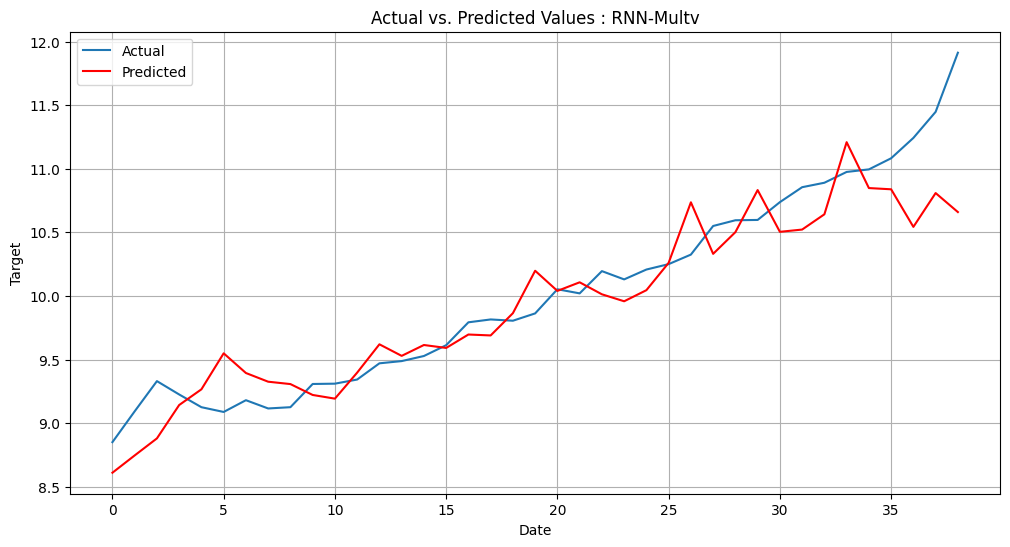

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_predict_rnn, label='Predicted', color='red')
plt.title('Actual vs. Predicted Values : RNN-Multv')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate the mean squared error
mse_train_rnn = mean_squared_error(Y_train_act, train_predict_rnn)
mse_test_rnn = mean_squared_error(y_test, test_predict_rnn)

# Calculate RMSE
rmse_train_rnn = np.sqrt(mse_train_rnn)
rmse_test_rnn = np.sqrt(mse_test_rnn)

# Calculate R²
r2_train_rnn = r2_score(Y_train_act, train_predict_rnn)
r2_test_rnn = r2_score(y_test, test_predict_rnn)

# Calculate MAE
mae_train_rnn = mean_absolute_error(Y_train_act, train_predict_rnn)
mae_test_rnn = mean_absolute_error(y_test, test_predict_rnn)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_train_rnn = mean_absolute_percentage_error(Y_train_act, train_predict_rnn)
mape_test_rnn = mean_absolute_percentage_error(y_test, test_predict_rnn)

# Print the metrics
print(f'Training MSE: {mse_train_rnn}')
print(f'Testing MSE: {mse_test_rnn}')
print(f'Training RMSE: {rmse_train_rnn}')
print(f'Testing RMSE: {rmse_test_rnn}')
print(f'Training R²: {r2_train_rnn}')
print(f'Testing R²: {r2_test_rnn}')
print(f'Training MAE: {mae_train_rnn}')
print(f'Testing MAE: {mae_test_rnn}')
print(f'Training MAPE: {mape_train_rnn}')
print(f'Testing MAPE: {mape_test_rnn}')


Training MSE: 0.04500726749464849
Testing MSE: 0.1063815863024163
Training RMSE: 0.21214916331357164
Testing RMSE: 0.32616190197878153
Training R²: 0.9950898902969784
Testing R²: 0.8212170955215863
Training MAE: 0.17527403540450184
Testing MAE: 0.23380764007568366
Training MAPE: 1.9353488647859698
Testing MAPE: 2.270094671160279


In [ ]:
pred_rnn = test_predict_rnn

# CV

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation
rnn_rmses = []
for train_index, test_index in tscv.split(X):
    val_X_train, val_X_test = X[train_index], X[test_index]
    val_y_train, val_y_test = Y[train_index], Y[test_index]

    # Create and train the RNN model
    model_rnn.fit(val_X_train, val_y_train, epochs=20)
    # Evaluate the model
    y_pred = model_rnn.predict(val_X_test)
    rmse = np.sqrt(mean_squared_error(inverse(y_scaler,val_y_test), inverse(y_scaler,y_pred)))
    rnn_rmses.append(rmse)
    print(f'Fold RMSE: {rmse}')

# Print average RMSE across folds
print(f'Average cross-validation RMSE: {np.mean(rnn_rmses)}')

Epoch 1/20
3/3 [==============================] - 0s 10ms/step - loss: 6.7322e-04
Epoch 2/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 3/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 4/20
3/3 [==============================] - 0s 7ms/step - loss: 9.7983e-04
Epoch 5/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 6/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 7/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 8/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 9/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 10/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 11/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 12/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 13/20
3/3 [==============================] - 0s 9ms/step

# LSTM

In [ ]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(112, return_sequences=True, input_shape=(time_step, X.shape[2])))
model_lstm.add(LSTM(112))
model_lstm.add(Dense(64))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.008962452499275811), loss='mean_squared_error')

# Train the model
model_lstm.fit(X_train, Y_train, epochs=100)


Epoch 1/100
11/11 [==============================] - 6s 14ms/step - loss: 0.1530
Epoch 2/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0141
Epoch 3/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0058
Epoch 4/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0037
Epoch 5/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0025
Epoch 6/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0023
Epoch 7/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0021
Epoch 8/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0017
Epoch 9/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0024
Epoch 10/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 11/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0017
Epoch 12/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0016
Epoch 13/100
11/11 [=====

In [ ]:
train_predict_lstm = inverse(y_scaler,model_lstm.predict(X_train))
test_predict_lstm = inverse(y_scaler,model_lstm.predict(X_test))

2/2 [==============================] - 0s 7ms/step


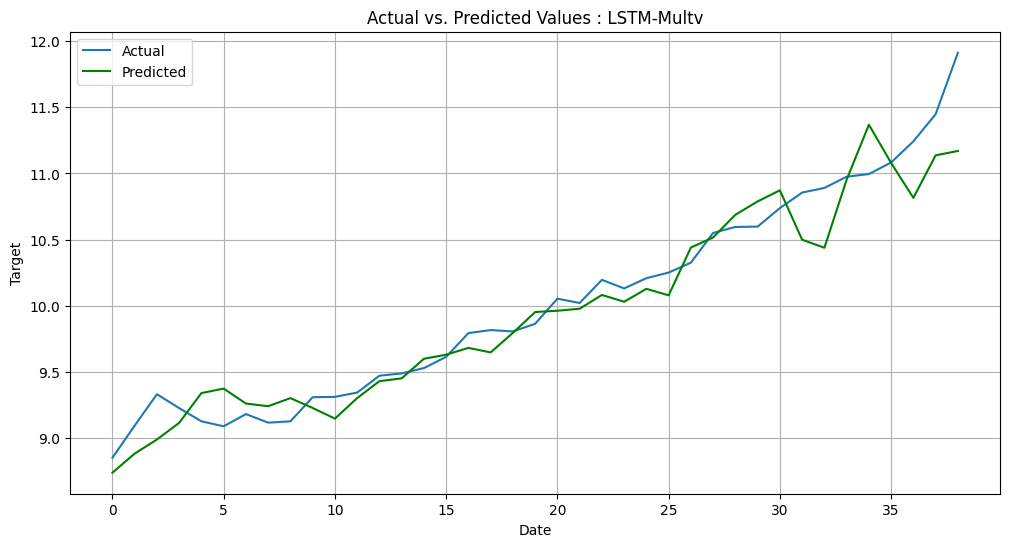

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_predict_lstm, label='Predicted', color='green')
plt.title('Actual vs. Predicted Values : LSTM-Multv')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculate the mean squared error
mse_train_lstm = mean_squared_error(Y_train_act,train_predict_lstm)
mse_test_lstm = mean_squared_error(y_test, test_predict_lstm)

# Calculate RMSE
rmse_train_lstm = np.sqrt(mse_train_lstm)
rmse_test_lstm = np.sqrt(mse_test_lstm)

# Calculate R²
r2_train_lstm = r2_score(Y_train_act, train_predict_lstm)
r2_test_lstm = r2_score(y_test, test_predict_lstm)

# Calculate MAE
mae_train_lstm = mean_absolute_error(Y_train_act, train_predict_lstm)
mae_test_lstm = mean_absolute_error(y_test, test_predict_lstm)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_train_lstm = mean_absolute_percentage_error(Y_train_act, train_predict_lstm)
mape_test_lstm = mean_absolute_percentage_error(y_test, test_predict_lstm)

# Print the metrics
print(f'Training MSE: {mse_train_lstm}')
print(f'Testing MSE: {mse_test_lstm}')
print(f'Training RMSE: {rmse_train_lstm}')
print(f'Testing RMSE: {rmse_test_lstm}')
print(f'Training R²: {r2_train_lstm}')
print(f'Testing R²: {r2_test_lstm}')
print(f'Training MAE: {mae_train_lstm}')
print(f'Testing MAE: {mae_test_lstm}')
print(f'Training MAPE: {mape_train_lstm}')
print(f'Testing MAPE: {mape_test_lstm}')


Training MSE: 0.04459799797898741
Testing MSE: 0.04896518961303854
Training RMSE: 0.21118238084411164
Testing RMSE: 0.22128079359275296
Training R²: 0.9951345399354004
Testing R²: 0.9177100180432594
Training MAE: 0.1570288375929016
Testing MAE: 0.16281437115791506
Training MAPE: 1.879441968250312
Testing MAPE: 1.5881953904727693


# CV

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation
lstm_rmses = []
for train_index, test_index in tscv.split(X):
    val_X_train, val_X_test = X[train_index], X[test_index]
    val_y_train, val_y_test = Y[train_index], Y[test_index]

    # Create and train the RNN model
    model_lstm.fit(val_X_train, val_y_train, epochs=20)
    # Evaluate the model
    y_pred = model_lstm.predict(val_X_test)
    rmse = np.sqrt(mean_squared_error(inverse(y_scaler,val_y_test), inverse(y_scaler,y_pred)))
    lstm_rmses.append(rmse)
    print(f'Fold RMSE: {rmse}')

# Print average RMSE across folds
print(f'Average cross-validation RMSE: {np.mean(lstm_rmses)}')

Epoch 1/20
3/3 [==============================] - 0s 23ms/step - loss: 2.4846e-04
Epoch 2/20
3/3 [==============================] - 0s 16ms/step - loss: 4.3081e-04
Epoch 3/20
3/3 [==============================] - 0s 15ms/step - loss: 0.0012
Epoch 4/20
3/3 [==============================] - 0s 14ms/step - loss: 7.2477e-04
Epoch 5/20
3/3 [==============================] - 0s 14ms/step - loss: 8.0012e-04
Epoch 6/20
3/3 [==============================] - 0s 14ms/step - loss: 4.0285e-04
Epoch 7/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0012
Epoch 8/20
3/3 [==============================] - 0s 13ms/step - loss: 5.8747e-04
Epoch 9/20
3/3 [==============================] - 0s 13ms/step - loss: 4.9274e-04
Epoch 10/20
3/3 [==============================] - 0s 13ms/step - loss: 9.0565e-04
Epoch 11/20
3/3 [==============================] - 0s 13ms/step - loss: 5.9004e-04
Epoch 12/20
3/3 [==============================] - 0s 13ms/step - loss: 4.3731e-04
Epoch 13/20
3/3 [====

# GRU

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model_gru.add(GRU(50))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_gru.fit(X_train, Y_train, epochs=100)


Epoch 1/100
11/11 [==============================] - 5s 7ms/step - loss: 0.0350
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0029
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 13/100
11/11 [===============

In [ ]:
train_predict_gru = inverse(y_scaler,model_gru.predict(X_train))
test_predict_gru = inverse(y_scaler,model_gru.predict(X_test))

2/2 [==============================] - 0s 7ms/step


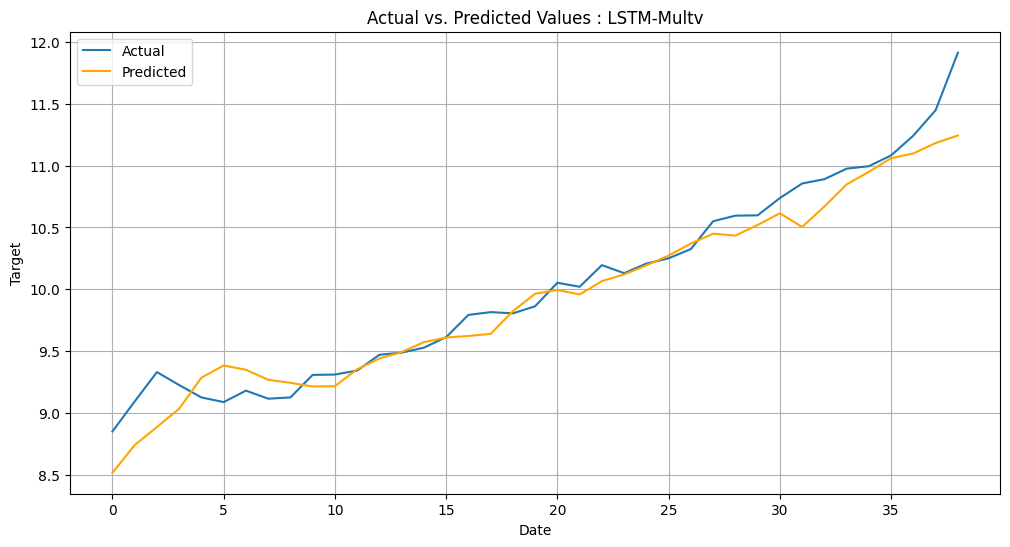

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_predict_gru, label='Predicted', color='orange')
plt.title('Actual vs. Predicted Values : LSTM-Multv')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculate the mean squared error
mse_train_gru = mean_squared_error(Y_train_act, train_predict_gru)
mse_test_gru = mean_squared_error(y_test, test_predict_gru)

# Calculate RMSE
rmse_train_gru = np.sqrt(mse_train_gru)
rmse_test_gru = np.sqrt(mse_test_gru)

# Calculate R²
r2_train_gru = r2_score(Y_train_act, train_predict_gru)
r2_test_gru = r2_score(y_test, test_predict_gru)

# Calculate MAE
mae_train_gru = mean_absolute_error(Y_train_act, train_predict_gru)
mae_test_gru = mean_absolute_error(y_test, test_predict_gru)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_train_gru = mean_absolute_percentage_error(Y_train_act, train_predict_gru)
mape_test_gru = mean_absolute_percentage_error(y_test, test_predict_gru)

# Print the metrics
print(f'Training MSE: {mse_train_gru}')
print(f'Testing MSE: {mse_test_gru}')
print(f'Training RMSE: {rmse_train_gru}')
print(f'Testing RMSE: {rmse_test_gru}')
print(f'Training R²: {r2_train_gru}')
print(f'Testing R²: {r2_test_gru}')
print(f'Training MAE: {mae_train_gru}')
print(f'Testing MAE: {mae_test_gru}')
print(f'Training MAPE: {mape_train_gru}')
print(f'Testing MAPE: {mape_test_gru}')


Training MSE: 0.08155825342186249
Testing MSE: 0.03984229715312246
Training RMSE: 0.2855840566660935
Testing RMSE: 0.19960535351819214
Training R²: 0.9911023264956976
Testing R²: 0.9330417805025204
Training MAE: 0.20170697035302365
Testing MAE: 0.14393356812305946
Training MAPE: 2.4723009834305656
Testing MAPE: 1.4362011676963733


# CV

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation
gru_rmses = []
for train_index, test_index in tscv.split(X):
    val_X_train, val_X_test = X[train_index], X[test_index]
    val_y_train, val_y_test = Y[train_index], Y[test_index]

    # Create and train the RNN model
    model_gru.fit(val_X_train, val_y_train, epochs=20)
    # Evaluate the model
    y_pred = model_gru.predict(val_X_test)
    rmse = np.sqrt(mean_squared_error(inverse(y_scaler,val_y_test), inverse(y_scaler,y_pred)))
    gru_rmses.append(rmse)
    print(f'Fold RMSE: {rmse}')

# Print average RMSE across folds
print(f'Average cross-validation RMSE: {np.mean(gru_rmses)}')

Epoch 1/20
3/3 [==============================] - 0s 9ms/step - loss: 3.7277e-04
Epoch 2/20
3/3 [==============================] - 0s 9ms/step - loss: 3.4372e-04
Epoch 3/20
3/3 [==============================] - 0s 12ms/step - loss: 5.0845e-04
Epoch 4/20
3/3 [==============================] - 0s 9ms/step - loss: 4.5814e-04
Epoch 5/20
3/3 [==============================] - 0s 10ms/step - loss: 5.3102e-04
Epoch 6/20
3/3 [==============================] - 0s 9ms/step - loss: 3.5073e-04
Epoch 7/20
3/3 [==============================] - 0s 9ms/step - loss: 3.8968e-04
Epoch 8/20
3/3 [==============================] - 0s 10ms/step - loss: 3.0858e-04
Epoch 9/20
3/3 [==============================] - 0s 10ms/step - loss: 4.2057e-04
Epoch 10/20
3/3 [==============================] - 0s 11ms/step - loss: 3.6984e-04
Epoch 11/20
3/3 [==============================] - 0s 11ms/step - loss: 5.0143e-04
Epoch 12/20
3/3 [==============================] - 0s 14ms/step - loss: 4.8765e-04
Epoch 13/20
3/3 [=